In [130]:
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from matplotlib import pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset

from aijack.attack import GradientInversion_Attack
from aijack.utils import NumpyDataset

from model.alexnet import AlexNet

In [131]:
tt = transforms.Compose([transforms.ToTensor()])
tp = transforms.ToPILImage()

train_dataset = torchvision.datasets.CIFAR10(
            root="/home/featurize/data",
            train=True,
            download=True
        )

if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Files already downloaded and verified
Running on cuda


In [132]:
# net = AlexNet(track=False).to(device)

# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.5, 0.5)
#     if hasattr(m, "bias"):
#         m.bias.data.uniform_(-0.5, 0.5)

# model_path = '/home/featurize/result/models/white_box_target_test_alexnet300.pth.tar'

# net = net.load_state_dict(torch.load(model_path,map_location=device))

# net.apply(weights_init)

criterion = cross_entropy_for_onehot

In [133]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 10)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out
    
net = LeNet().to(device)
    
net.apply(weights_init)

LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
    (6): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=10, bias=True)
  )
)

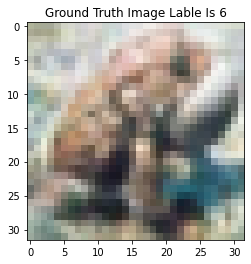

In [134]:
img_index = 154
gt_data = tt(train_dataset[img_index][0]).to(device)
gt_data = gt_data.view(1,*gt_data.size())
gt_label = torch.Tensor([train_dataset[img_index][1]]).long().to(device)
gt_label = gt_label.view(1,)
gt_onehot_label = label_to_onehot(gt_label,num_classes=10)

plt.imshow(tp(gt_data[0].cpu()))
plt.title('Ground Truth Image Lable Is {}'.format(gt_label.item()))

out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y,net.parameters())

original_dy_dx = list((_.detach().clone() + 0*torch.normal(0,0.4,size=_.shape,device=_.device) for _ in dy_dx))

# print(len(original_dy_dx))

Text(0.5, 1.0, 'Dummy Data And Lable Is 1')

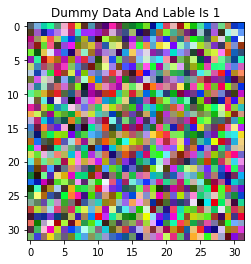

In [135]:
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tp(dummy_data[0].cpu()))
plt.title('Dummy Data And Lable Is {}'.format(torch.argmax(dummy_label,dim=-1).item()))

In [136]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label],lr=0.5)

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tp(dummy_data[0].cpu()))

0 36.9705
10 2.3315
20 0.2379
30 0.0753
40 0.0353
50 0.0211
60 0.0148
70 0.0112
80 0.0086
90 0.0068


Dummy label is 7.


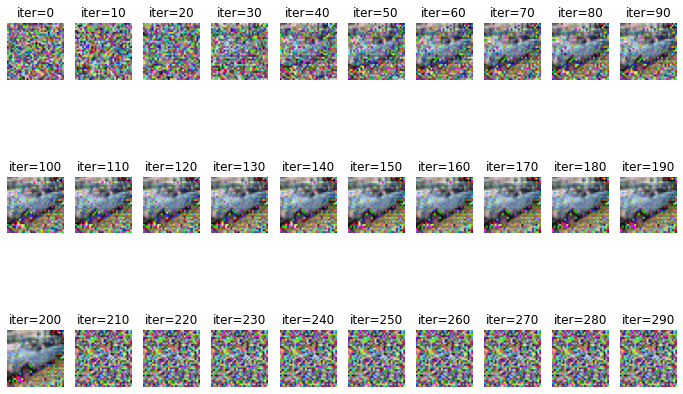

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())